<a href="https://colab.research.google.com/github/dbtjr1103/Basic_practice/blob/main/custom_augmentation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### 크롭한 것 12개 합치기

In [ ]:
import cv2
import matplotlib.pyplot as plt
import numpy as np
import glob
import random
from tqdm.notebook import tqdm

def crop_12(path_im,path_lb,iter_num):
    all_img = glob.glob(path_im + '/*.jpg') # 이미지 경로
    all_lbl = glob.glob(path_lb + '/*.txt') # 라벨 경로
    all_img.sort()
    all_lbl.sort() 
    for number in tqdm(range(iter_num)):
        data_list = random.sample(range(len(all_img)), 12)# 전체 경로의 파일수 중 12개 랜덤추출
        im_paths = [all_img[i] for i in data_list]
        lb_paths = [all_lbl[i] for i in data_list]
        # 라벨 담아줄 딕셔너리 / minmax는 박스 그리려고 생성
        new_label_dic = {'new_label_json': [], 'new_label_txt':[], 'new_label_minmax':[]}
        with open(path_lb + f'/concat12_image{number}.txt', "a") as f:
            f.truncate(0)
        for idx,(img_path,label_path) in enumerate(zip(im_paths,lb_paths)):
            # Load image
            plt.axis("off") # 축 제거
            img = cv2.imread(img_path)
            with open(label_path, "r") as f:
                data = f.readline()
            list_data = data.strip().split(' ')
            # 로보플로로 크롭한 이미지 -> 센터와 너비 높이로 구성
            x_center = 640*float(list_data[1])
            y_center = 640*float(list_data[2])
            width = 640*float(list_data[3])
            height = 640*float(list_data[4])
            # minmax 형식으로 변환
            ogn_x_min = x_center - (width/2)
            ogn_x_max = x_center + (width/2)
            ogn_y_min = y_center - (height/2)
            ogn_y_max = y_center + (height/2)
            # 새로운 라벨 사전작업 좌표이동 전
            bf_x_min = 0
            bf_x_max = ogn_x_max - ogn_x_min
            bf_y_min = 0
            bf_y_max = ogn_y_min - ogn_y_max
            # 라벨 txt 형식 좌표이동 전
            bf_ctr_x = (bf_x_max + bf_x_min) / 2
            bf_ctr_y = (bf_y_max + bf_y_min) / 2
            bf_width = bf_x_max
            bf_height = bf_y_max
            # 새로운 라벨 
            if idx < 6: # 위 이미지
                af_y_min = 20 # 패딩 준 만큽 
                af_y_max = 20 + 250
                af_x_min = idx*105 + 5
                af_x_max = idx*105 + 110
            else: # 아래 이미지
                af_y_min = 320 + 20
                af_y_max = 320 + 20 + 250
                af_x_min = (idx-6)*105 + 5
                af_x_max = (idx-6)*105 + 110
            # 새로운 라벨 - json 후
            af_ctr_x = (af_x_max + af_x_min) / 2
            af_ctr_y = (af_y_max + af_y_min) / 2
            af_width = af_x_max - af_x_min
            af_height = af_y_max - af_y_min
            # 새로운 라벨 비율 - txt 후
            ratio_x = af_ctr_x / 640
            ratio_y = af_ctr_y / 640
            ratio_width = af_width / 640
            ratio_height = af_height / 640
            # 박스 그리기용 
            new_label_minmax = f'{list_data[0]} {af_x_min} {af_x_max} {af_y_min} {af_y_max}'
            # json 라벨  x_min y_min x_max y_max
            new_label_json = f'{list_data[0]} {af_ctr_x} {af_ctr_y} {af_width} {af_height}' 
            # txt 라벨  x y width height
            new_label_txt = f'{list_data[0]} {ratio_x} {ratio_y} {ratio_width} {ratio_height}'
            # 라벨들 저장
            new_label_dic['new_label_json'].append(new_label_json)
            new_label_dic['new_label_txt'].append(new_label_txt)
            new_label_dic['new_label_minmax'].append(new_label_minmax)
            with open(path_lb + f'/concat12_image{number}.txt','a') as f:
                if idx == 11:
                    f.write(new_label_txt)
                else:
                    f.write(new_label_txt + '\n')
            #Cropped data(이미지 라벨로 크롭 후 자르기)
            start = (int(ogn_y_min),int(ogn_x_min))
            end = (int(ogn_y_max),int(ogn_x_max))
            output = np.zeros((end[0]-start[0], end[1]-start[1], 3), np.uint8)
            for y in range(output.shape[1]):
                for x in range(output.shape[0]):
                    xp, yp = x + start[0], y+start[1]
                    output[x,y] = img[xp,yp]
            if idx == 0: # 1행 6열 2개를 합치는 방식
                concat_img1 = output # 처음 크롭한 것은 concat1에 적절한 이미지 크기로 넣어줌
                concat_img1 = cv2.resize(concat_img1,(105,300))
            elif idx > 0 and idx < 6: # 2-6번째 이미지는 리사이즈 후 합침
                output = cv2.resize(output,(105,300))
                concat_img1 = cv2.hconcat([concat_img1,output]) # 가로로 합치는 코드
            elif idx == 6:
                concat_img1 = cv2.rectangle(concat_img1, (0, 320), (640, 250), (0, 0, 0), -1) # concat1 아래부분 가리기
                concat_img1 = cv2.copyMakeBorder(concat_img1,20,0,5,5,cv2.BORDER_CONSTANT) # concat1의 패딩
                concat_img2 = output # 2행 1열 이미지
                concat_img2 = cv2.resize(concat_img2,(105,300))
            elif idx == 11: # 마지막 concat후
                output = cv2.resize(output,(105,300))
                concat_img2 = cv2.hconcat([concat_img2,output])
                concat_img2 = cv2.rectangle(concat_img2, (0, 320), (640, 250), (0, 0, 0), -1) # concat2 아래부분 가리기
                concat_img2 = cv2.copyMakeBorder(concat_img2,20,0,5,5,cv2.BORDER_CONSTANT) # concat2의 패딩
            else: # 2행 나머지 concat2에 합치기
                output = cv2.resize(output,(105,300))
                concat_img2 = cv2.hconcat([concat_img2,output])
        # 만들어지 1행 6열 2개를 세로로 합침
        concat_img = cv2.vconcat([concat_img1,concat_img2])
        # print(concat_img.shape) # 크기확인
        # box 쳐주기 예시
        # for label in new_label_dic['new_label_minmax']:
        #     # print(label)
        #     label = label.split(' ')
        #     concat_img = cv2.rectangle(concat_img, (int(label[1]), int(label[3])),(int(label[2]), int(label[4])), (0, 255, 0), 2)
        # plt.imshow(concat_img)
        cv2.imwrite(path_im + f'/concat12_image{number}.jpg',concat_img)

### 크롭 한 것 48개 합치기 - 랜덤

In [ ]:
import cv2
import matplotlib.pyplot as plt
import numpy as np
import glob
import random
from tqdm.notebook import tqdm

def crop_48(path_im,path_lb,iter_num):
    all_img = glob.glob(path_im + '/*.jpg') # 이미지 경로
    all_lbl = glob.glob(path_lb + '/*.txt') # 라벨 경로
    all_img.sort()
    all_lbl.sort() 
    for number in tqdm(range(iter_num)):
        data_list = random.sample(range(len(all_img)), 48)# 전체 경로의 파일수 중 12개 랜덤추출
        im_paths = [all_img[i] for i in data_list]
        lb_paths = [all_lbl[i] for i in data_list]
        # 라벨 담아줄 딕셔너리 / minmax는 박스 그리려고 생성
        new_label_dic = {'new_label_json': [], 'new_label_txt':[], 'new_label_minmax':[]}
        with open(path_lb + f'/concat48_image{number}.txt', "a") as f:
            f.truncate(0)
        for idx,(img_path,label_path) in enumerate(zip(im_paths,lb_paths)):
            # Load image
            plt.axis("off") # 축 제거
            img = cv2.imread(img_path)
            with open(label_path, "r") as f:
                data = f.readline()
            list_data = data.strip().split(' ')
            # minmax 형식으로 변환
            ogn_x_min = 640*float(list_data[1]) - (640*float(list_data[3])/2)
            ogn_x_max = 640*float(list_data[1]) + (640*float(list_data[3])/2)
            ogn_y_min = 640*float(list_data[2]) - (640*float(list_data[4])/2)
            ogn_y_max = 640*float(list_data[2]) + (640*float(list_data[4])/2)
            # 라벨 txt 형식 좌표이동 전
            bf_ctr_x = (ogn_x_max - ogn_x_min + 0) / 2
            bf_ctr_y = (ogn_y_min - ogn_y_max + 0) / 2
            bf_width = ogn_x_max - ogn_x_min
            bf_height = ogn_y_min - ogn_y_max
            # 새로운 라벨         
            af_y_min = 160*(idx//12) + 10
            af_y_max = 160*(idx//12) + 10 + 125
            af_x_min = (idx-12*(idx//12))*53 + 2
            af_x_max = (idx-12*(idx//12))*53 + 55
            # 새로운 라벨 - json 후
            af_ctr_x = (af_x_max + af_x_min) / 2
            af_ctr_y = (af_y_max + af_y_min) / 2
            af_width = af_x_max - af_x_min
            af_height = af_y_max - af_y_min
            # 새로운 라벨 비율 - txt 후
            ratio_x = af_ctr_x / 640
            ratio_y = af_ctr_y / 640
            ratio_width = af_width / 640
            ratio_height = af_height / 640
            # 박스 그리기용 
            new_label_minmax = f'{list_data[0]} {af_x_min} {af_x_max} {af_y_min} {af_y_max}'
            # json 라벨  x_min y_min x_max y_max
            new_label_json = f'{list_data[0]} {af_ctr_x} {af_ctr_y} {af_width} {af_height}' 
            # txt 라벨  x y width height
            new_label_txt = f'{list_data[0]} {ratio_x} {ratio_y} {ratio_width} {ratio_height}'
            # 라벨들 저장
            new_label_dic['new_label_json'].append(new_label_json)
            new_label_dic['new_label_txt'].append(new_label_txt)
            new_label_dic['new_label_minmax'].append(new_label_minmax)
            with open(path_lb + f'/concat48_image{number}.txt','a') as f:
            # with open('/content/Dairy-Product-5/train2/labels' + f'/concat48_image{number}.txt','a') as f:
                if idx == 47:
                    f.write(new_label_txt)
                else:
                    f.write(new_label_txt + '\n')
            #Cropped data(이미지 라벨로 크롭 후 자르기)
            start = (int(ogn_y_min),int(ogn_x_min))
            end = (int(ogn_y_max),int(ogn_x_max))
            output = np.zeros((end[0]-start[0], end[1]-start[1], 3), np.uint8)
            for y in range(output.shape[1]):
                for x in range(output.shape[0]):
                    xp, yp = x + start[0], y+start[1]
                    output[x,y] = img[xp,yp]
            if idx == 0: # 1행 6열 2개를 합치는 방식
                concat_img1 = output # 처음 크롭한 것은 concat1에 적절한 이미지 크기로 넣어줌
                concat_img1 = cv2.resize(concat_img1,(53,150))
            elif idx > 0 and idx < 12: # 2-6번째 이미지는 리사이즈 후 합침
                output = cv2.resize(output,(53,150))
                concat_img1 = cv2.hconcat([concat_img1,output]) # 가로로 합치는 코드
            elif idx == 12 or idx == 24 or idx == 36:
                if idx == 12:
                    concat_img1 = cv2.rectangle(concat_img1, (0, 160), (640, 125), (0, 0, 0), -1) # concat1 아래부분 가리기
                    concat_img1 = cv2.copyMakeBorder(concat_img1,10,0,2,2,cv2.BORDER_CONSTANT)
                concat_img2 = output # 2행 1열 이미지
                concat_img2 = cv2.resize(concat_img2,(53,150))
            elif idx == 47 or idx == 23 or idx == 35: # 마지막 concat후
                output = cv2.resize(output,(53,150))
                concat_img2 = cv2.hconcat([concat_img2,output])
                concat_img2 = cv2.rectangle(concat_img2, (0, 160), (640, 125), (0, 0, 0), -1) # concat2 아래부분 가리기
                concat_img2 = cv2.copyMakeBorder(concat_img2,10,0,2,2,cv2.BORDER_CONSTANT) # concat2의 패딩
                concat_img1 = cv2.vconcat([concat_img1,concat_img2])
            elif idx > 12 and (idx not in [0,12,23,24,35,36,47]): # 2행 나머지 concat2에 합치기
                output = cv2.resize(output,(53,150))
                concat_img2 = cv2.hconcat([concat_img2,output])
        # print(concat_img1.shape) # 크기확인
        # # box 쳐주기 예시
        # for label in new_label_dic['new_label_minmax']:
        #     # print(label)
        #     label = label.split(' ')
        #     concat_img1 = cv2.rectangle(concat_img1, (int(label[1]), int(label[3])),(int(label[2]), int(label[4])), (0, 255, 0), 2)
        # plt.imshow(concat_img1)
        cv2.imwrite(path_im + f'/concat48_image{number}.jpg',concat_img1)
        # cv2.imwrite('/content/Dairy-Product-5/train2/images' + f'/concat48_image{number}.jpg',concat_img1)

In [ ]:
from roboflow import Roboflow
rf = Roboflow(api_key="qGwguWtA0jklwjG4hM6E")
project = rf.workspace("dairynew").project("dairy_new")
dataset = project.version(1).download("yolov8")

loading Roboflow workspace...
loading Roboflow project...


Extracting Dataset Version Zip to Dairy_New-1 in yolov8:: 100%|██████████| 2290/2290 [00:00<00:00, 2413.81it/s]


In [ ]:
path_im = '/content/Dairy_New-1/train/images'
path_lb = '/content/Dairy_New-1/train/labels'
print(len(glob.glob(path_im + '/*.jpg')),len(glob.glob(path_lb + '/*.txt')))

554 554


  0%|          | 0/1 [00:00<?, ?it/s]

555 555


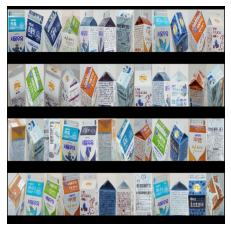

In [ ]:
crop_48(path_im,path_lb,1)
print(len(glob.glob(path_im + '/*.jpg')),len(glob.glob(path_lb + '/*.txt')))
img = cv2.imread('/content/Dairy_New-1/train/images/concat48_image0.jpg')
plt.imshow(img)

  0%|          | 0/1 [00:00<?, ?it/s]

556 556


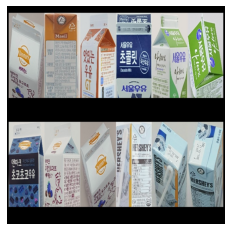

In [ ]:
crop_12(path_im,path_lb,1)
print(len(glob.glob(path_im + '/*.jpg')),len(glob.glob(path_lb + '/*.txt')))
img = cv2.imread('/content/Dairy_New-1/train/images/concat12_image0.jpg')
plt.imshow(img)

556 556


  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

754 754


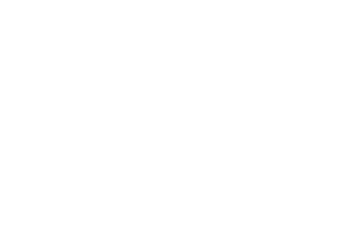

In [ ]:
path_im = '/content/Dairy_New-1/train/images'
path_lb = '/content/Dairy_New-1/train/labels'
print(len(glob.glob(path_im + '/*.jpg')),len(glob.glob(path_lb + '/*.txt')))
crop_48(path_im,path_lb,100)
crop_12(path_im,path_lb,100)
print(len(glob.glob(path_im + '/*.jpg')),len(glob.glob(path_lb + '/*.txt')))

In [ ]:
!pip install ultralytics

In [ ]:
!git clone https://github.com/dbtjr1103/YOLOv8.0.3.git

Cloning into 'YOLOv8.0.3'...
remote: Enumerating objects: 195, done.
remote: Counting objects: 100% (195/195), done.
remote: Compressing objects: 100% (163/163), done.
remote: Total 195 (delta 32), reused 138 (delta 25), pack-reused 0
Receiving objects: 100% (195/195), 907.10 KiB | 20.62 MiB/s, done.
Resolving deltas: 100% (32/32), done.


In [ ]:
cd YOLOv8.0.3

/content/YOLOv8.0.3


In [ ]:
!pip install -qr requirements.txt

In [ ]:
from ultralytics import YOLO
from IPython.display import display, Image
model = YOLO('yolov8n.pt')

  0%|          | 0.00/6.24M [00:00<?, ?B/s]

In [ ]:
from IPython import display
display.clear_output()
!yolo mode=checks

Ultralytics YOLOv8.0.5 🚀 Python-3.8.16 torch-1.13.0+cu116 CUDA:0 (Tesla T4, 15110MiB)
Setup complete ✅ (2 CPUs, 12.7 GB RAM, 23.2/166.8 GB disk)


In [ ]:
!yolo task=detect mode=train model=yolov8n.pt data=Dairy_New-1/data.yaml epochs=2 imgsz=640  --config-name=default.yaml --config-path=/content/YOLOv8.0.3/ultralytics/yolo/configs

Ultralytics YOLOv8.0.5 🚀 Python-3.8.16 torch-1.13.0+cu116 CUDA:0 (Tesla T4, 15110MiB)
yolo/engine/trainer: task=detect, mode=train, model=yolov8n.pt, data=Dairy_New-1/data.yaml, epochs=2, patience=50, batch=16, imgsz=640, save=True, cache=False, device=, workers=8, project=None, name=None, exist_ok=False, pretrained=False, optimizer=SGD, verbose=False, seed=0, deterministic=True, single_cls=False, image_weights=False, rect=False, cos_lr=False, close_mosaic=1, resume=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, show=False, save_txt=False, save_conf=False, save_crop=False, hide_labels=False, hide_conf=False, vid_stride=1, line_thickness=3, visualize=False, augment=False, agnostic_nms=False, retina_masks=False, format=torchscript, keras=False, optimize=False, int8=False, dynamic=False, simplify=False, opset=17, workspace=4, nms=False, lr0=0.01, lrf=0.01, m

In [ ]:
cd /content

/content


In [ ]:
!rm yolov8n.pt

#### 다른폴더 테스트

In [ ]:
import cv2
import matplotlib.pyplot as plt
import numpy as np
import glob
import random
from tqdm.notebook import tqdm

def crop_48(path_im,path_lb,iter_num):
    all_img = glob.glob(path_im + '/*.jpg') # 이미지 경로
    all_lbl = glob.glob(path_lb + '/*.txt') # 라벨 경로
    all_img.sort()
    all_lbl.sort() 
    for number in tqdm(range(iter_num)):
        data_list = random.sample(range(len(all_img)), 48)# 전체 경로의 파일수 중 12개 랜덤추출
        im_paths = [all_img[i] for i in data_list]
        lb_paths = [all_lbl[i] for i in data_list]
        # 라벨 담아줄 딕셔너리 / minmax는 박스 그리려고 생성
        new_label_dic = {'new_label_json': [], 'new_label_txt':[], 'new_label_minmax':[]}
        with open('/content/Dairy_New-1/train2/labels' + f'/concat48_image{number}.txt', "a") as f:
            f.truncate(0)
        for idx,(img_path,label_path) in enumerate(zip(im_paths,lb_paths)):
            # Load image
            plt.axis("off") # 축 제거
            img = cv2.imread(img_path)
            with open(label_path, "r") as f:
                data = f.readline()
            list_data = data.strip().split(' ')
            # minmax 형식으로 변환
            ogn_x_min = 640*float(list_data[1]) - (640*float(list_data[3])/2)
            ogn_x_max = 640*float(list_data[1]) + (640*float(list_data[3])/2)
            ogn_y_min = 640*float(list_data[2]) - (640*float(list_data[4])/2)
            ogn_y_max = 640*float(list_data[2]) + (640*float(list_data[4])/2)
            # 라벨 txt 형식 좌표이동 전
            bf_ctr_x = (ogn_x_max - ogn_x_min + 0) / 2
            bf_ctr_y = (ogn_y_min - ogn_y_max + 0) / 2
            bf_width = ogn_x_max - ogn_x_min
            bf_height = ogn_y_min - ogn_y_max
            # 새로운 라벨         
            af_y_min = 160*(idx//12) + 10
            af_y_max = 160*(idx//12) + 10 + 125
            af_x_min = (idx-12*(idx//12))*53 + 2
            af_x_max = (idx-12*(idx//12))*53 + 55
            # 새로운 라벨 - json 후
            af_ctr_x = (af_x_max + af_x_min) / 2
            af_ctr_y = (af_y_max + af_y_min) / 2
            af_width = af_x_max - af_x_min
            af_height = af_y_max - af_y_min
            # 새로운 라벨 비율 - txt 후
            ratio_x = af_ctr_x / 640
            ratio_y = af_ctr_y / 640
            ratio_width = af_width / 640
            ratio_height = af_height / 640
            # 박스 그리기용 
            new_label_minmax = f'{list_data[0]} {af_x_min} {af_x_max} {af_y_min} {af_y_max}'
            # json 라벨  x_min y_min x_max y_max
            new_label_json = f'{list_data[0]} {af_ctr_x} {af_ctr_y} {af_width} {af_height}' 
            # txt 라벨  x y width height
            new_label_txt = f'{list_data[0]} {ratio_x} {ratio_y} {ratio_width} {ratio_height}'
            # 라벨들 저장
            new_label_dic['new_label_json'].append(new_label_json)
            new_label_dic['new_label_txt'].append(new_label_txt)
            new_label_dic['new_label_minmax'].append(new_label_minmax)
            with open('/content/Dairy_New-1/train2/labels' + f'/concat48_image{number}.txt','a') as f:
            # with open('/content/Dairy-Product-5/train2/labels' + f'/concat48_image{number}.txt','a') as f:
                if idx == 47:
                    f.write(new_label_txt)
                else:
                    f.write(new_label_txt + '\n')
            #Cropped data(이미지 라벨로 크롭 후 자르기)
            start = (int(ogn_y_min),int(ogn_x_min))
            end = (int(ogn_y_max),int(ogn_x_max))
            output = np.zeros((end[0]-start[0], end[1]-start[1], 3), np.uint8)
            for y in range(output.shape[1]):
                for x in range(output.shape[0]):
                    xp, yp = x + start[0], y+start[1]
                    output[x,y] = img[xp,yp]
            if idx == 0: # 1행 6열 2개를 합치는 방식
                concat_img1 = output # 처음 크롭한 것은 concat1에 적절한 이미지 크기로 넣어줌
                concat_img1 = cv2.resize(concat_img1,(53,150))
            elif idx > 0 and idx < 12: # 2-6번째 이미지는 리사이즈 후 합침
                output = cv2.resize(output,(53,150))
                concat_img1 = cv2.hconcat([concat_img1,output]) # 가로로 합치는 코드
            elif idx == 12 or idx == 24 or idx == 36:
                if idx == 12:
                    concat_img1 = cv2.rectangle(concat_img1, (0, 160), (640, 125), (0, 0, 0), -1) # concat1 아래부분 가리기
                    concat_img1 = cv2.copyMakeBorder(concat_img1,10,0,2,2,cv2.BORDER_CONSTANT)
                concat_img2 = output # 2행 1열 이미지
                concat_img2 = cv2.resize(concat_img2,(53,150))
            elif idx == 47 or idx == 23 or idx == 35: # 마지막 concat후
                output = cv2.resize(output,(53,150))
                concat_img2 = cv2.hconcat([concat_img2,output])
                concat_img2 = cv2.rectangle(concat_img2, (0, 160), (640, 125), (0, 0, 0), -1) # concat2 아래부분 가리기
                concat_img2 = cv2.copyMakeBorder(concat_img2,10,0,2,2,cv2.BORDER_CONSTANT) # concat2의 패딩
                concat_img1 = cv2.vconcat([concat_img1,concat_img2])
            elif idx > 12 and (idx not in [0,12,23,24,35,36,47]): # 2행 나머지 concat2에 합치기
                output = cv2.resize(output,(53,150))
                concat_img2 = cv2.hconcat([concat_img2,output])
        # print(concat_img1.shape) # 크기확인
        # # box 쳐주기 예시
        # for label in new_label_dic['new_label_minmax']:
        #     # print(label)
        #     label = label.split(' ')
        #     concat_img1 = cv2.rectangle(concat_img1, (int(label[1]), int(label[3])),(int(label[2]), int(label[4])), (0, 255, 0), 2)
        # plt.imshow(concat_img1)
        cv2.imwrite('/content/Dairy_New-1/train2/images' + f'/concat48_image{number}.jpg',concat_img1)
        # cv2.imwrite('/content/Dairy-Product-5/train2/images' + f'/concat48_image{number}.jpg',concat_img1)

  0%|          | 0/1 [00:00<?, ?it/s]

556 556


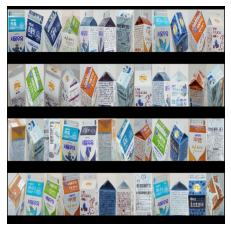

In [ ]:
crop_48(path_im,path_lb,1)
print(len(glob.glob(path_im + '/*.jpg')),len(glob.glob(path_lb + '/*.txt')))
img = cv2.imread('/content/Dairy_New-1/train/images/concat48_image0.jpg')
plt.imshow(img)

# 재시도


In [ ]:
!pip install ultralytics

In [ ]:
!pip install roboflow --quiet

In [ ]:
import os
HOME = os.getcwd()
print(HOME)

/content


In [ ]:
from IPython import display
display.clear_output()
!yolo mode=checks

Ultralytics YOLOv8.0.5 🚀 Python-3.8.16 torch-1.13.0+cu116 CUDA:0 (Tesla T4, 15110MiB)
Setup complete ✅ (8 CPUs, 51.0 GB RAM, 23.2/166.8 GB disk)


In [ ]:
%cd {HOME}
!git clone https://github.com/ultralytics/ultralytics-roboflow.git

/content
fatal: destination path 'ultralytics-roboflow' already exists and is not an empty directory.


In [ ]:
%cd {HOME}/ultralytics-roboflow
!pip install -r requirements.txt

In [ ]:
from ultralytics import YOLO

from IPython.display import display, Image

In [ ]:
from roboflow import Roboflow
rf = Roboflow(api_key="vJw7gZYxURcrIZe9csOU")
project = rf.workspace("mainpj").project("main-iqccr")
dataset = project.version(4).download("yolov8")

In [ ]:
model = YOLO("yolov8n.yaml")


                   from  n    params  module                                       arguments                     
  0                  -1  1       464  ultralytics.nn.modules.Conv                  [3, 16, 3, 2]                 
  1                  -1  1      4672  ultralytics.nn.modules.Conv                  [16, 32, 3, 2]                
  2                  -1  1      7360  ultralytics.nn.modules.C2f                   [32, 32, 1, True]             
  3                  -1  1     18560  ultralytics.nn.modules.Conv                  [32, 64, 3, 2]                
  4                  -1  2     49664  ultralytics.nn.modules.C2f                   [64, 64, 2, True]             
  5                  -1  1     73984  ultralytics.nn.modules.Conv                  [64, 128, 3, 2]               
  6                  -1  2    197632  ultralytics.nn.modules.C2f                   [128, 128, 2, True]           
  7                  -1  1    295424  ultralytics.nn.modules.Conv                  [128

In [ ]:
%cd {HOME}/ultralytics-roboflow

!yolo task=detect mode=train model=yolov8n.pt data=/content/ultralytics-roboflow/main-4/data.yaml epochs=1 imgsz=480

/content/ultralytics-roboflow
Ultralytics YOLOv8.0.5 🚀 Python-3.8.16 torch-1.13.0+cu116 CUDA:0 (Tesla T4, 15110MiB)
yolo/engine/trainer: task=detect, mode=train, model=yolov8n.pt, data=/content/ultralytics-roboflow/main-4/data.yaml, epochs=1, patience=50, batch=16, imgsz=480, save=True, cache=False, device=, workers=8, project=None, name=None, exist_ok=False, pretrained=False, optimizer=SGD, verbose=False, seed=0, deterministic=True, single_cls=False, image_weights=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, show=False, save_txt=False, save_conf=False, save_crop=False, hide_labels=False, hide_conf=False, vid_stride=1, line_thickness=3, visualize=False, augment=False, agnostic_nms=False, retina_masks=False, format=torchscript, keras=False, optimize=False, int8=False, dynamic=False, simplify=False,

In [ ]:
!yolo cfg=/content/ultralytics-roboflow/ultralytics/yolo/configs/default.yaml

Overriding default config with /content/ultralytics-roboflow/ultralytics/yolo/configs/default.yaml
Ultralytics YOLOv8.0.5 🚀 Python-3.8.16 torch-1.13.0+cu116 CUDA:0 (Tesla T4, 15110MiB)
yolo/engine/trainer: task=detect, mode=train, model=yolov8n.pt, data=/content/ultralytics-roboflow/main-4/data.yaml, epochs=1, patience=50, batch=16, imgsz=480, save=True, cache=False, device=, workers=8, project=None, name=None, exist_ok=False, pretrained=False, optimizer=SGD, verbose=False, seed=0, deterministic=True, single_cls=False, image_weights=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, show=False, save_txt=False, save_conf=False, save_crop=False, hide_labels=False, hide_conf=False, vid_stride=1, line_thickness=3, visualize=False, augment=False, agnostic_nms=False, retina_masks=False, format=torchscript, ke